In [1]:
import sys
sys.path.insert(0, '../../../PyPlr')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyplr.CIE import get_CIES026
from pyplr.oceanops import predict_dark_spds, calibrated_radiance

# Spectral sensitivities

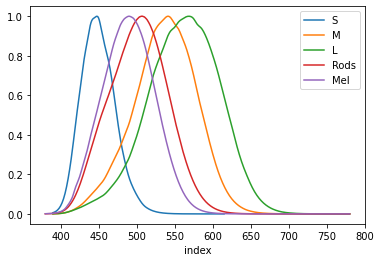

In [2]:
_ , sss = get_CIES026(asdf=True)
#sss = sss[::5] # downsample to 5nm bins
sss.plot()
sss = sss.fillna(0)

# Look at the calibration file

,px_num,rmse,p00,p10,p01,p20,p11,p30,p21
0,1,68.5404,1419.51,19.7992,0.000009,-1.017550,-0.000002,0.013992,7.751080e-08
1,2,63.5620,1424.72,19.0778,0.000007,-0.973644,-0.000002,0.013298,6.828400e-08
2,3,94.6511,1393.66,25.9959,0.000015,-1.367870,-0.000003,0.019168,1.197420e-07
3,4,76.6288,1409.92,22.3085,0.000009,-1.151110,-0.000003,0.015905,8.740110e-08
4,5,77.1790,1409.23,22.1413,0.000011,-1.143820,-0.000002,0.015801,9.111080e-08
...,...,...,...,...,...,...,...,...,...
1019,1020,100.2610,1397.42,25.6654,0.000017,-1.385740,-0.000003,0.019714,1.343550e-07
1020,1021,88.9935,1402.29,24.1808,0.000014,-1.279940,-0.000003,0.017946,1.133880e-07
1021,1022,91.5782,1400.22,24.5777,0.000016,-1.307330,-0.000003,0.018403,1.183780e-07
1022,1023,93.3579,1395.59,26.0278,0.000014,-1.367500,-0.000003,0.019107,1.153350e-07


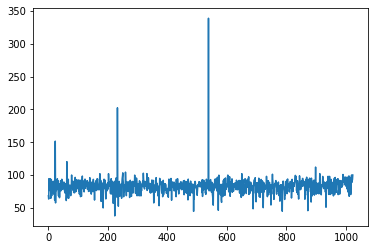

In [3]:
dc = pd.read_table('../data/oo_dark_cal.txt', skiprows=2, sep='\t', index_col=False)
dc.rmse.plot()
dc

# Get calibrated radiance data

In [5]:
# Gather some data
oo_spectra      = pd.read_csv('../data/oo_led_intensity_spectra_08-17-20-14-31.csv')
oo_info         = pd.read_csv('../data/oo_led_intensity_info_08-17-20-14-31.csv')
cal_per_wl      = pd.read_csv('../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv('../data/oo_sensorArea.csv', header=None)

# predict dark_spds and get calibrated radiance
oo_dark_spds = predict_dark_spds(oo_info, '../data/oo_dark_cal.txt')
wperm2pernm  = calibrated_radiance(oo_spectra, oo_info, oo_dark_spds, cal_per_wl, sensor_area_cm2)

# Replace indices
wperm2pernm['led'] = oo_info['led']
wperm2pernm['intensity'] = oo_info['intensity']
wperm2pernm.set_index(['led', 'intensity'], inplace=True)
wperm2pernm.sort_index(inplace=True)
wperm2pernm.columns = sss.index

In [23]:
wperm2pernm.interpolate(axis=1, inplace=True)

In [24]:
alphaopicradiance = wperm2pernm.dot(sss)
#wperm2pernm.index
#wperm2pernm.index
alphaopicradiance.loc[(0,)]


,S,M,L,Rods,Mel
intensity,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000
65,0.077994,0.006116,0.004333,0.021464,0.027279
130,0.233941,0.021861,0.017274,0.067325,0.084463
195,0.449481,0.046540,0.038485,0.133431,0.165881
260,0.878299,0.094826,0.079768,0.264240,0.327298
...,...,...,...,...,...
3835,8.770151,0.992072,0.827760,2.733664,3.365525
3900,8.865093,1.001098,0.834535,2.762230,3.401229
3965,8.989973,1.012131,0.842581,2.799826,3.448525


In [120]:
# Take 0-1 and turn it into 4095
x = np.random.rand(1, 2)
np.round(x*4095)

array([[3840., 2748.]])

In [26]:
alphaopicradiance

S         M         L      Rods       Mel
led intensity                                                  
0   0          0.000000  0.000000  0.000000  0.000000  0.000000
    65         0.077994  0.006116  0.004333  0.021464  0.027279
    130        0.233941  0.021861  0.017274  0.067325  0.084463
    195        0.449481  0.046540  0.038485  0.133431  0.165881
    260        0.878299  0.094826  0.079768  0.264240  0.327298
...                 ...       ...       ...       ...       ...
9   3835       0.260510  0.618211  3.081128  0.343274  0.315302
    3900       0.258470  0.620820  3.127524  0.339679  0.311531
    3965       0.254134  0.623444  3.155879  0.337661  0.308640
    4030       0.258653  0.625849  3.159285  0.341225  0.312662
    4095       0.261095  0.629559  3.176827  0.343231  0.314356

[640 rows x 5 columns]

In [27]:
def interp_spectra(spectra):
    '''
    This function needs generalising.

    Parameters
    ----------
    spectra : TYPE
        DESCRIPTION.

    Returns
    -------
    intp_tbl : TYPE
        DESCRIPTION.

    '''
    #tbl = spectra.unstack(level=0)
    #tbl.columns = [val[1] for val in tbl.columns]
    
    intp_tbl = pd.DataFrame()
    for led, df in spectra.groupby(['led']):
        intensities = df.index.get_level_values('intensity')
        new_intensities = np.linspace(intensities.min(), intensities.max(), 4096)
        new_intensities = new_intensities.astype('int')
        df.reset_index(inplace=True, drop=True)
        df.columns = range(0, df.shape[1])
        df.index = df.index * 63
        n = df.reindex(new_intensities).interpolate(method='linear')
        n['intensity'] = n.index
        n['led'] = led
        intp_tbl = intp_tbl.append(n)
    intp_tbl.set_index(['led','intensity'], inplace=True)
    return intp_tbl

In [28]:
#alphaopicradiance.set_index(['led','intensity'], inplace=True)
d = interp_spectra(alphaopicradiance)
d.columns = sss.columns
d

S         M         L      Rods       Mel
led intensity                                                  
0   0          0.000000  0.000000  0.000000  0.000000  0.000000
    1          0.001238  0.000097  0.000069  0.000341  0.000433
    2          0.002476  0.000194  0.000138  0.000681  0.000866
    3          0.003714  0.000291  0.000206  0.001022  0.001299
    4          0.004952  0.000388  0.000275  0.001363  0.001732
...                 ...       ...       ...       ...       ...
9   4091       0.261095  0.629559  3.176827  0.343231  0.314356
    4092       0.261095  0.629559  3.176827  0.343231  0.314356
    4093       0.261095  0.629559  3.176827  0.343231  0.314356
    4094       0.261095  0.629559  3.176827  0.343231  0.314356
    4095       0.261095  0.629559  3.176827  0.343231  0.314356

[40960 rows x 5 columns]

In [133]:
rv = np.random.rand()
rv = int(np.round(rv * 4095))
rv

1927

In [134]:
d.loc[(0,rv)]

S       4.650262e-06
M       5.130690e-07
L       4.302337e-07
Rods    1.421213e-06
Mel     1.755670e-06
Name: (0, 1927), dtype: float64